#### Import required libraries

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
# import plotly.graph_objects as go


# from sklearn.ensemble import IsolationForest

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import seaborn as sns #visualisation


In [31]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

#### Read the dataset
- integrate the data with normal and attack

In [32]:
# import data set from the local driver
dff=pd.read_csv('drive/My Drive/Colab Notebooks/SWaT_Dataset_Normal_v0.csv')#, parse_dates = ['Timestamp'], index_col = 'Timestamp')
df=pd.read_csv('drive/My Drive/Colab Notebooks/SWaT_Dataset_Attack_v0 - Copy.csv')#, parse_dates = ['Timestamp'], index_col = 'Timestamp')
frames = [dff,df]
df_concat=pd.concat(frames)
df_concat.head(5)

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


#### Automatic Sensor data extraction  

In [33]:
# # select sensor data
df1=df_concat.filter(regex='(^Time|^PIT|^AIT|^FIT|^DPI|^LIT|^Norma)',axis=1)#.head()
df1.head()
df1.shape

(946719, 27)

In [34]:
# remove the space on Normal/Attack columns
df1['Normal/Attack'] = df1['Normal/Attack'].str.replace(' ', '')
#To see how the data is spread betwen Attack and Normal
print(df1.groupby('Normal/Attack')['Normal/Attack'].count())
# Rename the col name Normal/Attack with A
df1.rename(columns = {'Normal/Attack':'A'}, inplace = True)
df1.head(2)

Normal/Attack
Attack     54621
Normal    892098
Name: Normal/Attack, dtype: int64


<ipython-input-34-048a2842c303>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Normal/Attack'] = df1['Normal/Attack'].str.replace(' ', '')
<ipython-input-34-048a2842c303>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns = {'Normal/Attack':'A'}, inplace = True)


,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,22/12/2015 4:00:00 PM,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,Normal


In [35]:
# Convert non-numeric to numeric

df1.A[df1.A== 'Normal'] = 0
df1.A[df1.A == 'Attack'] = 1
df1.head()

<ipython-input-35-c24e48151b45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A== 'Normal'] = 0
<ipython-input-35-c24e48151b45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A== 'Normal'] = 0
<ipython-input-35-c24e48151b45>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A == 'Attack'] = 1
<ipython-input-35-c24e48151b45>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,22/12/2015 4:00:00 PM,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
1,22/12/2015 4:00:01 PM,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
2,22/12/2015 4:00:02 PM,2.439548,260.9131,244.3284,8.19008,306.101,2.467305,20.84320,2.233354,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
3,22/12/2015 4:00:03 PM,2.428338,260.2850,244.3284,8.19008,306.101,2.466536,20.84320,2.233354,327.2799,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
4,22/12/2015 4:00:04 PM,2.424815,259.8925,244.4245,8.19008,306.101,2.466536,20.84320,2.233354,327.1597,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0


In [36]:
# convert the data type to float
df1['A'] = df1['A'].astype('float')

<ipython-input-36-e14d35a4be6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['A'] = df1['A'].astype('float')


In [37]:
# make the Timestamp to datetime datatype
df1['Timestamp'] = pd.to_datetime(df1['Timestamp']) # conveting the date time stamp to the timestamp series
df1.head()
# # df1.shape

#df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])

#df1.head()

<ipython-input-37-5fd3e043a7d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Timestamp'] = pd.to_datetime(df1['Timestamp']) # conveting the date time stamp to the timestamp series


,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,2015-12-22 16:00:00,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
1,2015-12-22 16:00:01,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2,2015-12-22 16:00:02,2.439548,260.9131,244.3284,8.19008,306.101,2.467305,20.84320,2.233354,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
3,2015-12-22 16:00:03,2.428338,260.2850,244.3284,8.19008,306.101,2.466536,20.84320,2.233354,327.2799,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
4,2015-12-22 16:00:04,2.424815,259.8925,244.4245,8.19008,306.101,2.466536,20.84320,2.233354,327.1597,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0


In [38]:
# make Timestamp feature  as index
df1= df1.set_index('Timestamp')
df1.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:01,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:02,2.439548,260.9131,244.3284,8.19008,306.101,2.467305,20.84320,2.233354,327.4401,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:03,2.428338,260.2850,244.3284,8.19008,306.101,2.466536,20.84320,2.233354,327.2799,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:04,2.424815,259.8925,244.4245,8.19008,306.101,2.466536,20.84320,2.233354,327.1597,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0


##### Interpolation the data with each time stamp

In [39]:
# resample the data with 5 second
df1=df1.resample('5s').mean()
df1.interpolate(method='polynomial',order=2)
df1.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.444032,260.77178,244.34762,8.190080,306.10100,2.468048,20.825276,2.233969,327.35198,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:05,2.513980,260.59906,244.62956,8.190080,306.10100,2.467741,20.831038,2.234686,326.95144,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:10,2.641322,261.67458,244.87950,8.190080,306.05486,2.473072,20.827198,2.234302,326.47080,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:15,2.597893,261.05440,245.03330,8.190080,305.87030,2.473969,20.870094,2.235147,327.78456,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:20,2.521731,262.10636,245.44990,8.190849,305.87030,2.472970,20.836804,2.235147,328.58562,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0


In [40]:
# Count NaN values of whole DataFrame
nan_count = df1.isna().sum()#.sum()
print(nan_count )

FIT101     518415
LIT101     518415
AIT201     518415
AIT202     518415
AIT203     518415
FIT201     518415
DPIT301    518415
FIT301     518415
LIT301     518415
AIT401     518415
AIT402     518415
FIT401     518415
LIT401     518415
AIT501     518415
AIT502     518415
AIT503     518415
AIT504     518415
FIT501     518415
FIT502     518415
FIT503     518415
FIT504     518415
PIT501     518415
PIT502     518415
PIT503     518415
FIT601     518415
A          518415
dtype: int64


In [41]:
df1.fillna(method = 'ffill', inplace = True)

In [42]:
df1.shape

(707760, 26)

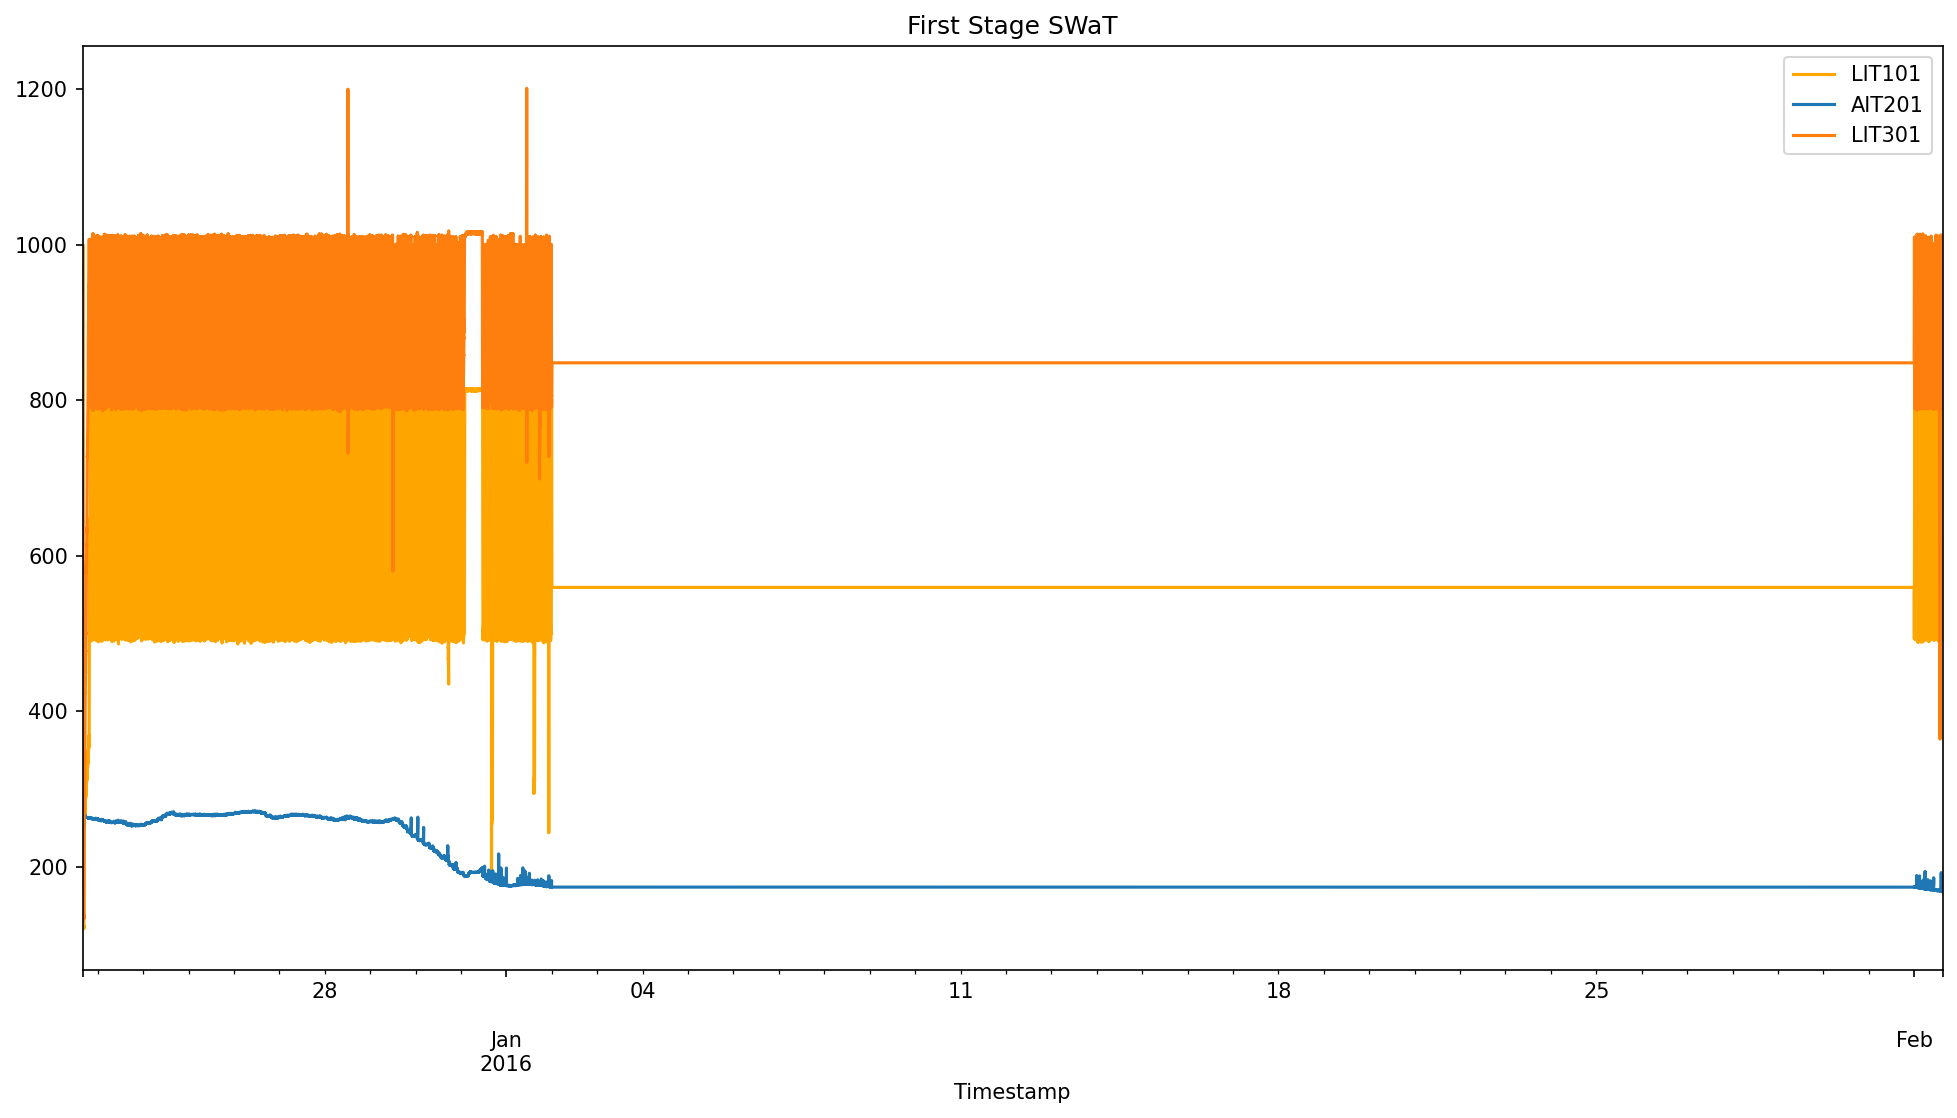

In [43]:
# code
# Visualizing The first stage with respect to time series

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
#df1['FIT101'].plot(label='FIT101')
df1['LIT101'].plot(label='LIT101', color='orange')
df1['AIT201'].plot(label='AIT201')

df1['LIT301'].plot(label='LIT301')

# adding title to the plot
plt.title('First Stage SWaT')
# adding Label to the x-axis
plt.xlabel('Timestamp')
# adding legend to the curve
plt.legend()

In [44]:
# df1= df1.drop('Timestamp', axis=1)

In [45]:
# make the class label into 2 since during sampling and interpolation it create the new class labels
df1.loc[df1['A'] >= 0.2, 'lablel'] = 1
df1.loc[df1['A'] ==0.0, 'lablel'] = 0

In [46]:
df1

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A,lablel
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.444032,260.77178,244.34762,8.190080,306.10100,2.468048,20.825276,2.233969,327.35198,0.0000,...,0.001666,0.001409,0.001664,0.000000,10.02948,0.000000,4.277749,0.000256,0.0,0.0
2015-12-22 16:00:05,2.513980,260.59906,244.62956,8.190080,306.10100,2.467741,20.831038,2.234686,326.95144,0.0000,...,0.001666,0.001409,0.001664,0.000000,10.02948,0.000000,4.277749,0.000256,0.0,0.0
2015-12-22 16:00:10,2.641322,261.67458,244.87950,8.190080,306.05486,2.473072,20.827198,2.234302,326.47080,0.0000,...,0.001666,0.001409,0.001664,0.000000,10.02948,0.000000,4.277749,0.000256,0.0,0.0
2015-12-22 16:00:15,2.597893,261.05440,245.03330,8.190080,305.87030,2.473969,20.870094,2.235147,327.78456,0.0000,...,0.001666,0.001409,0.001664,0.000000,10.02948,0.000000,4.277749,0.000256,0.0,0.0
2015-12-22 16:00:20,2.521731,262.10636,245.44990,8.190849,305.87030,2.472970,20.836804,2.235147,328.58562,0.0000,...,0.001666,0.001409,0.001664,0.000000,10.02948,0.000000,4.277749,0.000256,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-01 14:59:35,2.445633,519.44746,168.09790,8.643233,301.84570,2.458924,20.407838,2.197790,975.15060,148.8032,...,1.713509,1.274267,0.734885,0.308426,251.33296,0.977157,189.038100,0.000000,0.0,0.0
2016-02-01 14:59:40,2.496877,518.02650,168.09790,8.643489,301.84570,2.460898,20.376462,2.197098,976.01580,148.8032,...,1.715099,1.268349,0.734885,0.308426,251.21760,0.925896,188.909940,0.000000,0.0,0.0
2016-02-01 14:59:45,2.645230,516.64482,168.09790,8.642528,301.84570,2.461359,20.336768,2.194254,975.96774,148.8032,...,1.713714,1.275932,0.734885,0.308426,251.24966,0.925896,188.964400,0.000000,0.0,0.0


In [47]:
# fill the missing values with forward and backward of the cols

df1=df1.fillna(method="ffill")

In [48]:
df1.isna().sum()

FIT101     0
LIT101     0
AIT201     0
AIT202     0
AIT203     0
FIT201     0
DPIT301    0
FIT301     0
LIT301     0
AIT401     0
AIT402     0
FIT401     0
LIT401     0
AIT501     0
AIT502     0
AIT503     0
AIT504     0
FIT501     0
FIT502     0
FIT503     0
FIT504     0
PIT501     0
PIT502     0
PIT503     0
FIT601     0
A          0
lablel     0
dtype: int64

#### Visualize the dataset
-  Plotting the number of normal and Attack transactions in the dataset.

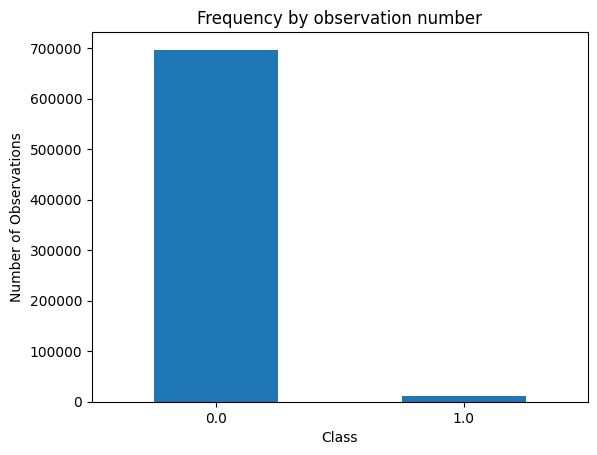

In [49]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(df1['lablel'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(df1['lablel'].unique())))#, df1.A.unique()))
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [50]:
df1= df1.drop('A', axis=1)

In [51]:
# count the number of anomalies and normal data points in our dataset
df1['lablel'].value_counts()


0.0    696805
1.0     10955
Name: lablel, dtype: int64

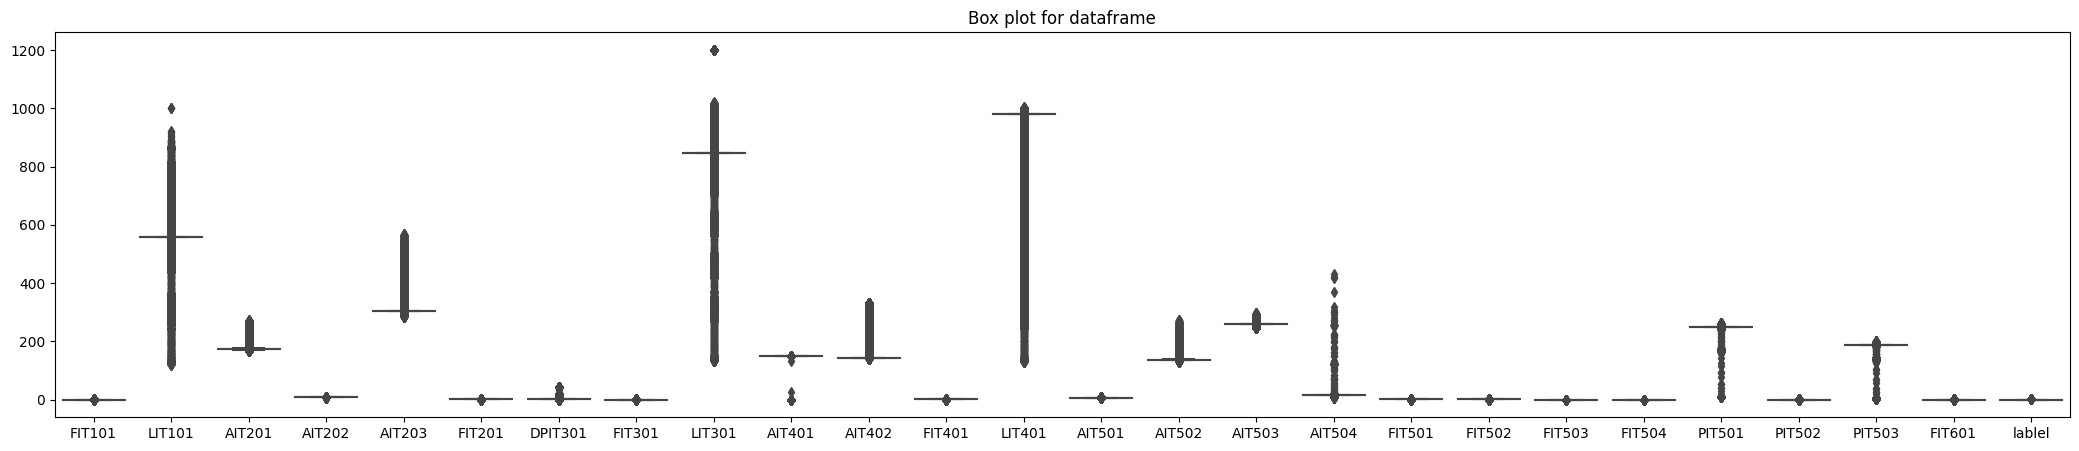

In [52]:
# checking the outlier in the data
# sns.boxplot(data=df)
fig = plt.figure(figsize=(26,5))
sns.boxplot(data=df1)
# plt.xticks([1,2],['Our data', 'Hypothetical data'])
# plt.ylabel('Grade')
plt.title('Box plot for dataframe')
plt.show()

### SMOTE - Balancing the class
- The accuracy comes out to be 83  % but it is not our concern evalution techniques  
It demonstrates how biased the model is in favor of the majority class. It thus demonstrates that this paradigm is not the optimal one.

- We will now use various approaches for handling unbalanced data and evaluate the results for accuracy, precision, and recall.

In [53]:
from imblearn.over_sampling import SMOTE

# Assuming df is your DataFrame with features and target variable
X = df1.drop('lablel', axis=1)
y = df1['lablel']

# Create SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new balanced DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
df_resampled.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel
0,2.444032,260.77178,244.34762,8.190080,306.10100,2.468048,20.825276,2.233969,327.35198,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
1,2.513980,260.59906,244.62956,8.190080,306.10100,2.467741,20.831038,2.234686,326.95144,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2,2.641322,261.67458,244.87950,8.190080,306.05486,2.473072,20.827198,2.234302,326.47080,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
3,2.597893,261.05440,245.03330,8.190080,305.87030,2.473969,20.870094,2.235147,327.78456,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
4,2.521731,262.10636,245.44990,8.190849,305.87030,2.472970,20.836804,2.235147,328.58562,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0


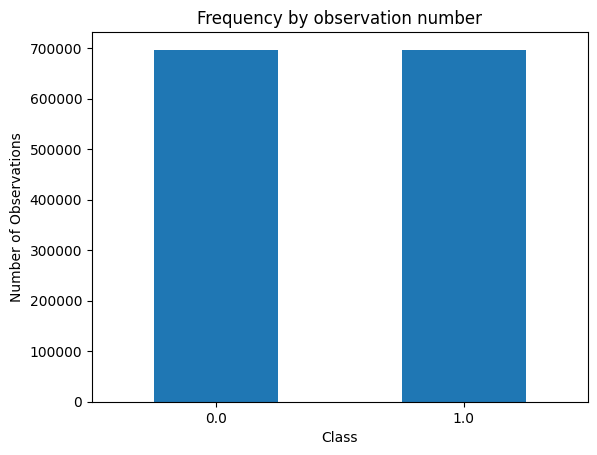

In [54]:
#Visualizing the balanced dataset
count_classes2 = pd.value_counts(df_resampled['lablel'], sort = True)
count_classes2.plot(kind = 'bar', rot=0)
plt.xticks(range(len(df_resampled['lablel'].unique())))#, df1.A.unique()))
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

### Normalize using Min max Scaler

In [55]:
# # For content length, use the Min max Scalar.
# from sklearn.preprocessing import MinMaxScaler

con_feats = ['FIT101','LIT101','AIT201','AIT202','AIT203','FIT201','DPIT301','FIT301','FIT301','LIT301','AIT401',
            'AIT402','FIT401','LIT401','AIT501','AIT502','AIT503','AIT504','FIT501','FIT502','FIT503','FIT504',
            'PIT501','PIT502','PIT503','FIT601']
scaler = MinMaxScaler()
df_resampled[con_feats] = scaler.fit_transform(df_resampled[con_feats])
df_resampled.head(5)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel
0,0.894293,0.159184,0.731315,0.732954,0.073596,0.873447,0.462669,0.948655,0.181982,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
1,0.919888,0.158988,0.734017,0.732954,0.073596,0.873338,0.462797,0.948960,0.181607,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
2,0.966483,0.160211,0.736412,0.732954,0.073433,0.875225,0.462712,0.948797,0.181156,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
3,0.950592,0.159506,0.737886,0.732954,0.072778,0.875542,0.463665,0.949156,0.182387,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
4,0.922724,0.160702,0.741878,0.733212,0.072778,0.875188,0.462925,0.949156,0.183137,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0


In [56]:
# Taking a random sample of 10% of the data
df_resampled = df_resampled.sample(frac=0.1, random_state=42)
df_resampled.shape

(139361, 26)

#### Hyperparamter Tuning for 5 second on SWaT dataset

In [57]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd

# Load and preprocess your data
#data = pd.read_csv('your_data.csv')
X = df_resampled.drop('lablel', axis=1)
y = df_resampled['lablel']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the function to create the autoencoder model
def create_autoencoder(optimizer='adam', loss='mean_squared_error', activation='relu', hidden_units=16):
    model = Sequential()
    model.add(Dense(units=hidden_units, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dense(units=X_train.shape[1], activation=activation))
    model.compile(optimizer=optimizer, loss=loss)
    return model

# Create the KerasRegressor wrapper
autoencoder = KerasRegressor(build_fn=create_autoencoder, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'loss': ['mean_squared_error', 'mean_absolute_error'],
    'activation': ['relu', 'sigmoid'],
    #'hidden_layers': [1,2,3,4,5,6],
    'hidden_units': [4,8, 16, 32,64,128,256],
    'epochs': [10,15,20,30],
    'batch_size': [10,32, 64],

}

# Perform random search
random_search = RandomizedSearchCV(estimator=autoencoder, param_distributions=param_grid, cv=3, n_iter=10)
random_search.fit(X_train, X_train)


# Get the best model and its hyperparameters
best_autoencoder = random_search.best_estimator_
best_parameters = random_search.best_params_

# Evaluate the best model on the test data
reconstruction_error = best_autoencoder.score(X_test, X_test)



print("Best Parameters:", best_parameters)
print("Reconstruction Error:", reconstruction_error)
# store parameters in a dataframe
pd.DataFrame.from_dict(random_search.best_params_, orient='index', columns=['Assigned Value']).sort_index()



<ipython-input-57-e340d444a956>:26: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  autoencoder = KerasRegressor(build_fn=create_autoencoder, verbose=0)


Best Parameters: {'optimizer': 'adam', 'loss': 'mean_squared_error', 'hidden_units': 4, 'epochs': 30, 'batch_size': 32, 'activation': 'sigmoid'}
Reconstruction Error: -0.002297155326232314


,Assigned Value
activation,sigmoid
batch_size,32
epochs,30
hidden_units,4
loss,mean_squared_error
optimizer,adam


In [59]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV

# Load and preprocess your data
#data = pd.read_csv('your_data.csv')
X = df_resampled.drop('lablel', axis=1)
y = df_resampled['lablel']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the function to create the autoencoder model
def create_autoencoder(hidden_layers=1, hidden_units=16):
    model = Sequential()
    model.add(Dense(units=hidden_units, activation='relu', input_shape=(X_train.shape[1],)))

    for _ in range(hidden_layers):
        model.add(Dense(units=hidden_units, activation='relu'))

    model.add(Dense(units=X_train.shape[1], activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the KerasRegressor wrapper
autoencoder = KerasRegressor(build_fn=create_autoencoder, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'hidden_layers': [1, 2, 3] # Possible number of hidden layers
    #'hidden_units': [8, 16, 32, 64],  # Possible number of units in each layer
    #'epochs': [10, 20],
    #'batch_size': [32, 64]
}

# Perform grid search cross-validation
grid = RandomizedSearchCV(estimator=autoencoder, param_distributions=param_grid, cv=5)
grid_result = grid.fit(X_train, X_train)

# Print the best hyperparameters and the corresponding mean cross-validated score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Evaluate the model on the testing set
best_model = grid_result.best_estimator_.model
mse = best_model.evaluate(X_test, X_test)
print("Mean Squared Error on Testing Set:", mse)


<ipython-input-59-d1267047ca5f>:30: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  autoencoder = KerasRegressor(build_fn=create_autoencoder, verbose=0)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best: -0.001937 using {'hidden_layers': 1}
872/872 [==============================] - 2s 2ms/step - loss: 0.0014
Mean Squared Error on Testing Set: 0.0013947088737040758
